# Simulation of a 2D Ising model by the Metropolis algorithm

### 5.1 Exercise
**Program** Write a program that simulates a 2D Ising model with periodic boundary conditions by using the
 Metropolis acceptance matric $a_{ij}$ and the matrix $\Gamma_{ij}$ based on the local spin-flip (Glauber) proposed
 move.

**Simulation** By assuming $k_B = 1$ and $J = 1$ simulate the 2D Ising model for different values of temperatures
 (at least 3, one below, one above, and one close to the critical temperature $T_c = \frac{2}{\ln{1+\sqrt{2}}}$
and 3 different values of L (for instance 25,50 and 100).

**Equilibration time, averages and fluctuations** After having determined the equilibrium time and disregarding the samples for $t < \tau_{eq}$ estimate the ensemble averages of the magnetisation per spin, the energy per spin, and the corresponding fluctuations (specific heat and magnetic susceptibility)

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
from IPython.display import display, Math
from load_data import load_matrices_from_file, get_matrix, load_from_file, get_collection

In [2]:
%%time
# load data: all data have been collected together in order to enhance computational speed
spins = load_matrices_from_file('ising_new.txt')
energies = load_from_file('ising_energies_new.txt')
magnetizations = load_from_file('ising_magnetizations_new.txt')

CPU times: total: 3min 15s
Wall time: 3min 44s


In [2]:
def variance(A, avg_A):
    # MC estimate of the variance, as described in the notes
    return np.sum((A-avg_A)**2)/(A.shape[0]-1)

def cv(T, A, avg_A):
    return variance(A, avg_A)/(T**2)

def chi(T, A, avg_A, L):
    return L*L*variance(A, avg_A)/T
    
def equilibrium_stat(M, E, T, L, tail):
    # in order to identify the equilibrium time, I selected a "tail" number of elements and calculated the mean and average of them
    # the idea is that in the last tail elements, the equilibrium has been reached and this information can be used to identify 
    # all elements in the range mean(tail) +- std(tail) as equilibium values, and consequently the equilibration time
    m_last = np.mean(M[-tail:])
    m_last_std = np.std(M[-tail:])
    t_eq = np.where((M >= m_last - m_last_std) & (M <= m_last + m_last_std))[0][0]

    # remove all the elements before equilibrium time
    m_eq = M[t_eq:]
    e_eq = E[t_eq:]

    # calculate averages and sigmas 
    avg_M = np.mean(m_eq)
    sigma_M = np.sqrt(variance(m_eq,avg_M)/m_eq.shape[0]) # error on the mean
    avg_E = np.mean(e_eq)
    sigma_E = np.sqrt(variance(e_eq,avg_E)/e_eq.shape[0]) # error on the mean
    specific_heat = cv(T, e_eq, avg_E)
    magnetic_susceptibility = chi(T, m_eq, avg_M, L)
    return t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility

In [3]:
# temperatures considered in the simulations
T_C = 2/np.log(1+np.sqrt(2))
T_range = [np.around(T_C/2,2), np.around((T_C*0.98),2), np.around(T_C*2,2)]

# lattex sizes considered in the simulations
L_range = [25, 50,100]

# useful for plots
labels = [1/2, 0.98, 2]

# compute the thermodynamic limit of magnetization as comparison with experimental results
M_lim = [(1 - (1 / np.sinh(2 / T))**2)**(1/8) if T < T_C else 0 for T in T_range]

# MC steps for which I have saved the spin configuration for graphical representation
i_range_tot = []
N = [100000, 1000000, 10000000]
for n in N:
    l = [0]
    for i in np.linspace(3,0,4, dtype="int"):
        l.append(int(n/(10**i)))
    i_range_tot.append(l)

### **L=25**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

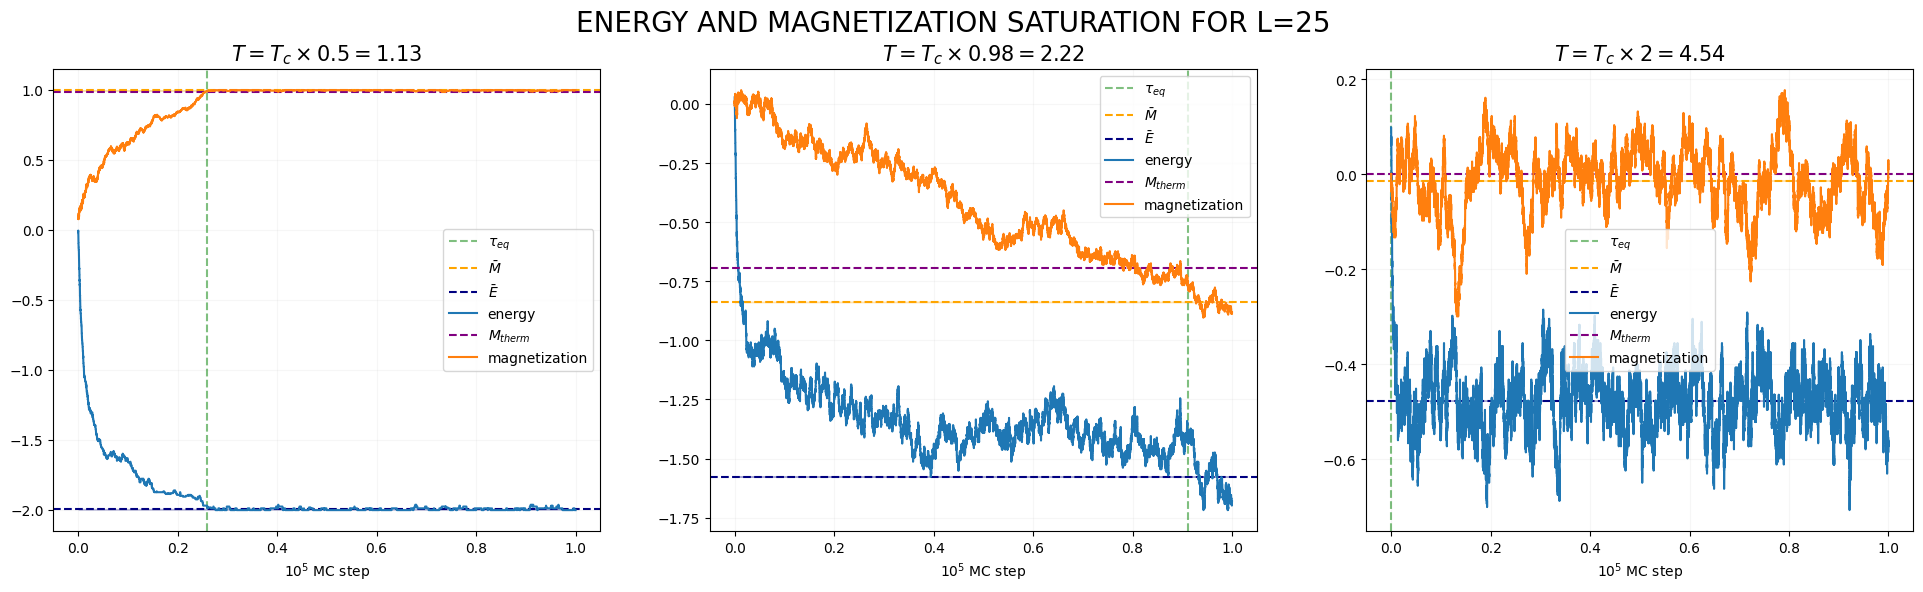

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=len(L_range),figsize=(24,6))
L = L_range[0]
plt.suptitle("ENERGY AND MAGNETIZATION SATURATION FOR L={}".format(L), fontsize=20)
for j, T in enumerate(T_range):
    
    M = get_collection(magnetizations, np.around(T,2), L)
    E = get_collection(energies, np.around(T,2), L)
    x_range = [i/10**5 for i in range(E.shape[0])]
    
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, int(len(x_range)/10))
    display(Math(r"T={:.2f}: \tau_{{eq}}={}, \bar{{E}} = {:.5f} \pm {:.5f}, \bar{{M}} = {:.5f} \pm {:.5f}, C_V = {:.5f}, \chi = {:.5f}".format(T, t_eq, avg_E, sigma_E, avg_M, sigma_M, specific_heat, magnetic_susceptibility)))   
    ax[j].axvline(t_eq/10**5, label=r"$\tau_{eq}$", color="green", linestyle="--", alpha=0.5)
    ax[j].axhline(avg_M, label=r"$\bar{{M}}$", color="orange", linestyle="--")
    ax[j].fill_between(x_range, avg_M - sigma_M, avg_M + sigma_M, color="orange", alpha=0.3)
    ax[j].axhline(avg_E, label=r"$\bar{{E}}$", color="navy", linestyle="--")
    ax[j].fill_between(x_range, avg_E - sigma_E, avg_E + sigma_E, color="navy", alpha=0.3)
        
    ax[j].plot(x_range, E, label="energy")
    ax[j].axhline(M_lim[j]*np.sign(M[-1]), label=r"$M_{therm}$", color="purple", linestyle="--")
    ax[j].plot(x_range, M, label="magnetization")

    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    
plt.show()

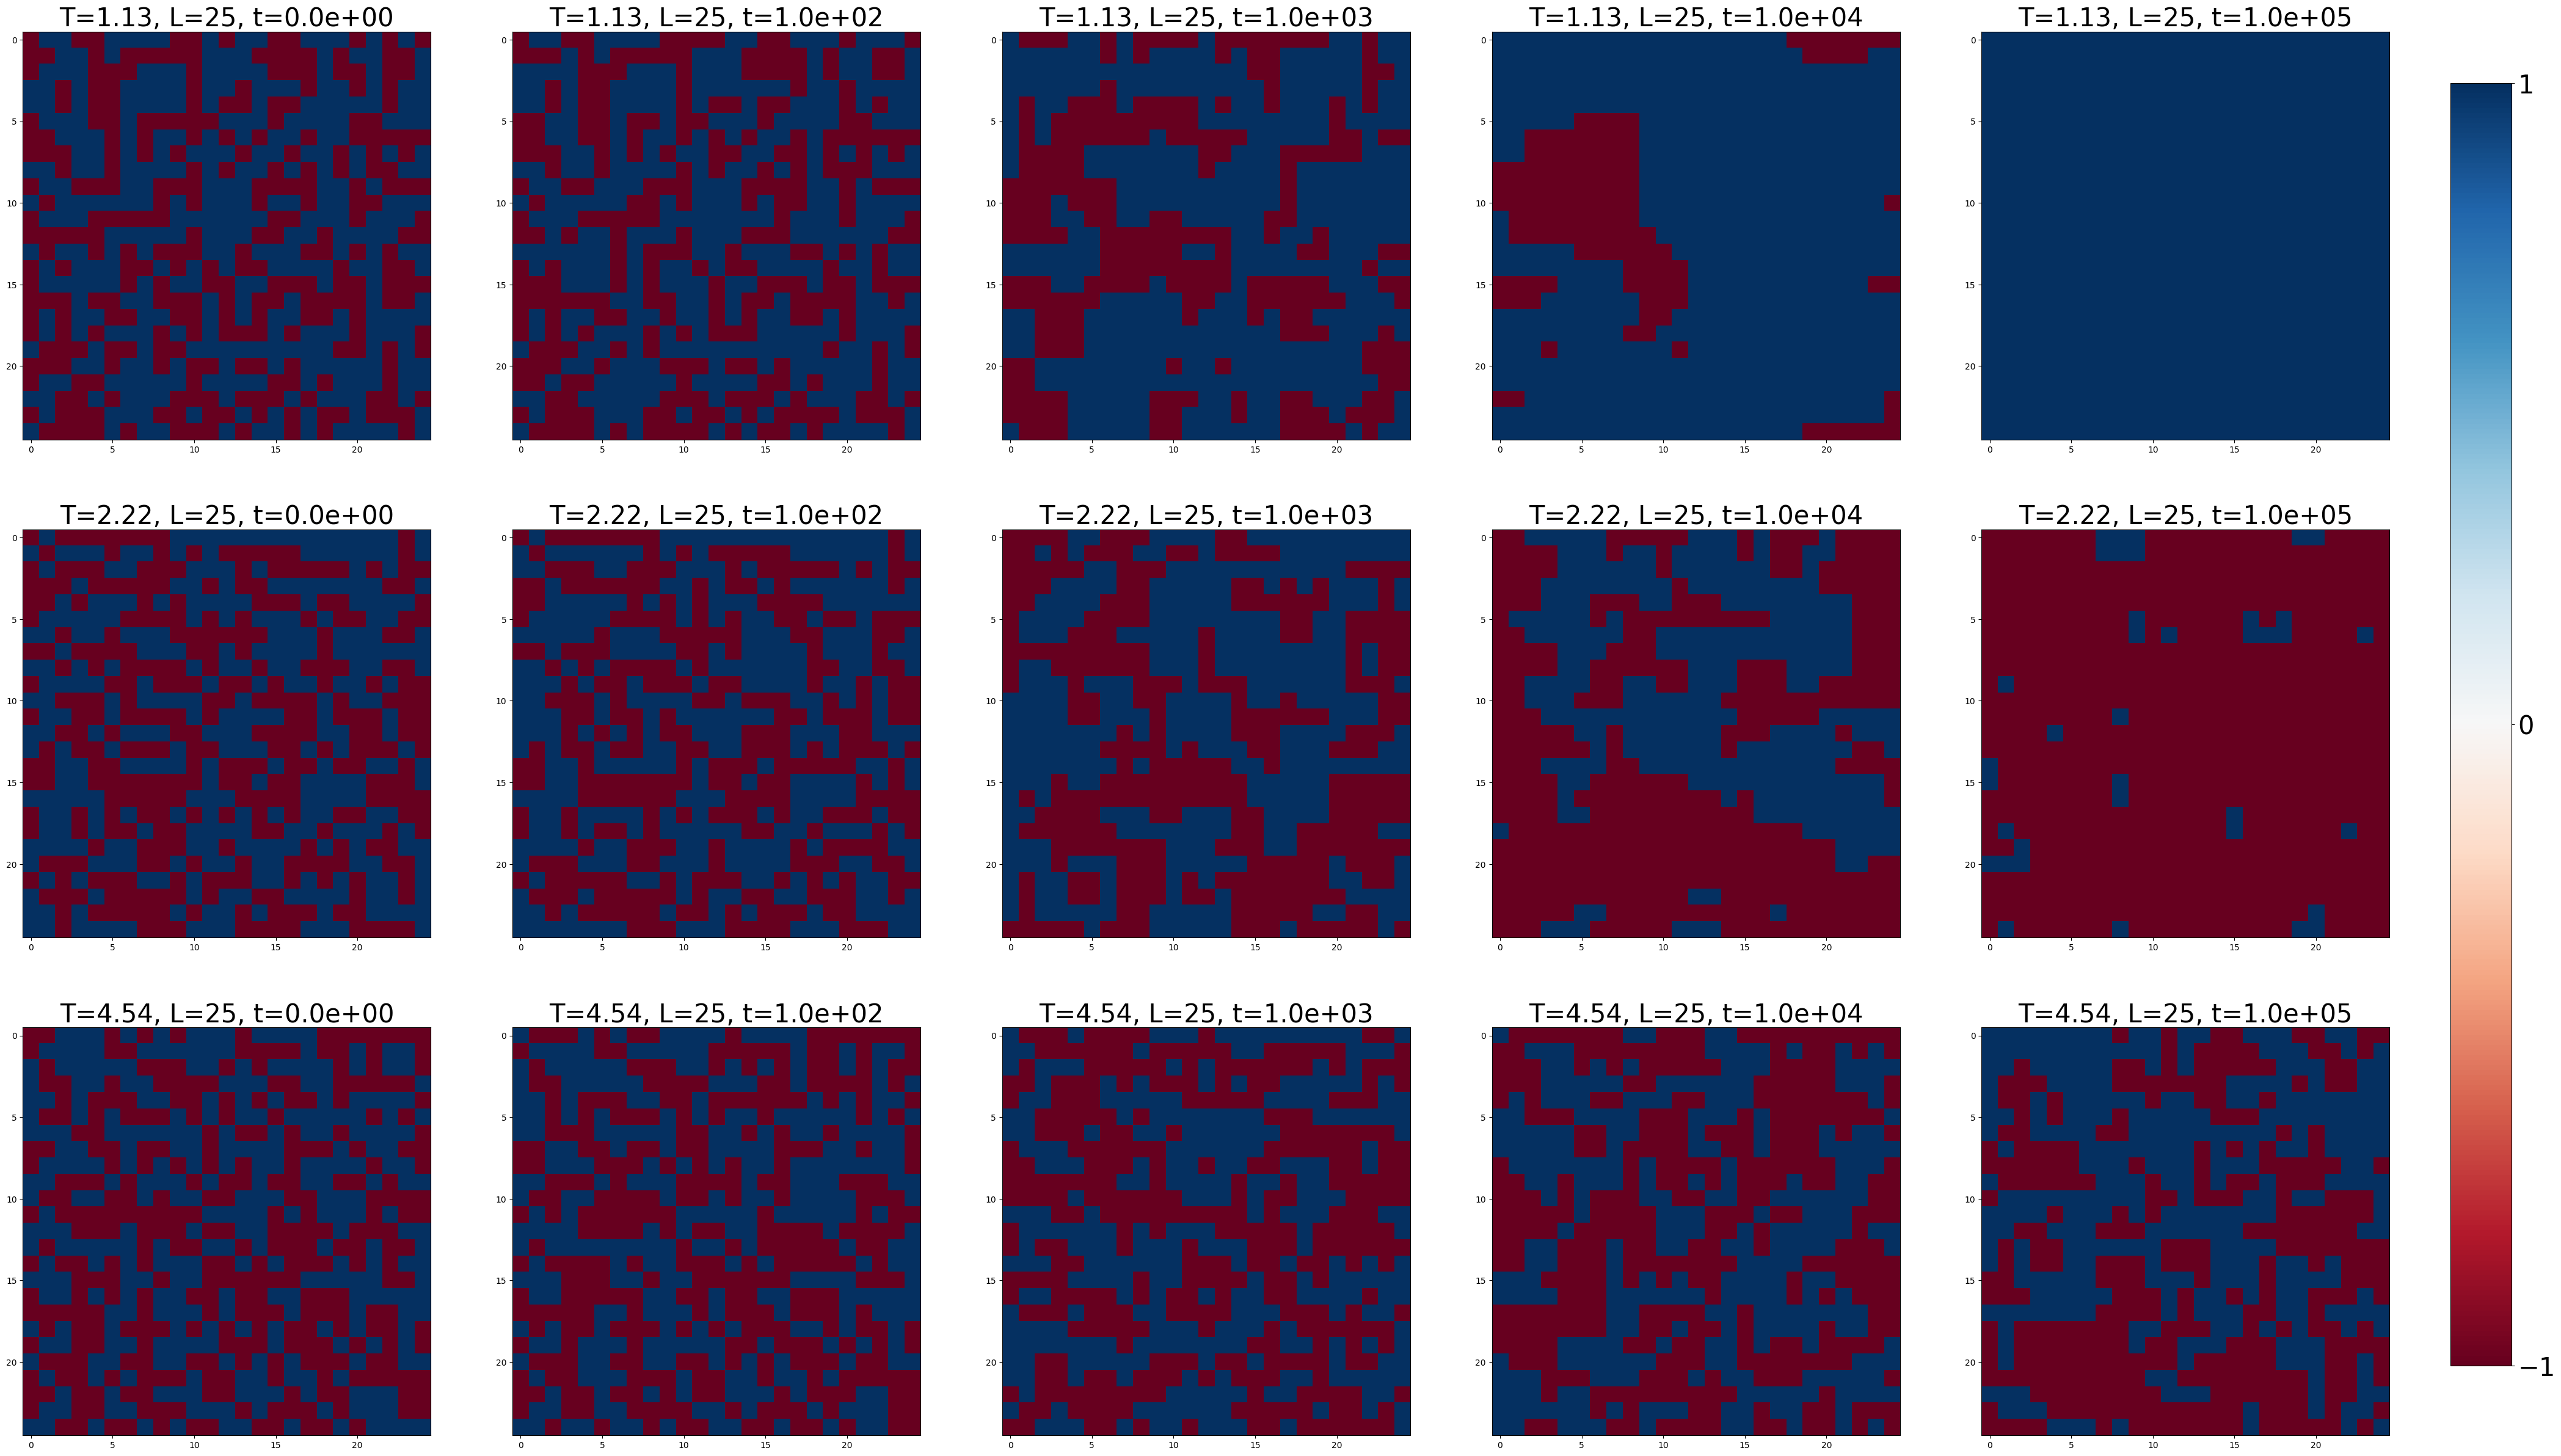

In [13]:
cmap = plt.get_cmap('RdBu') 
t_range = i_range_tot[0]
L_mesh, i_mesh = np.meshgrid(L_range, t_range, indexing='ij')
fig, ax = plt.subplots(nrows=len(T_range), ncols=len(t_range),figsize=(len(t_range)*10,10*len(T_range)))
for j, T in enumerate(T_range):
    for k, t in enumerate(t_range):
        matrix = get_matrix(spins, np.around(T,2), L, t)
        im = ax[j][k].imshow(matrix, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
        ax[j][k].set_title("T={:.2f}, L={}, t={:.1e}".format(T, L, t), fontsize=30)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=30) 
plt.show()

## **L=50**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

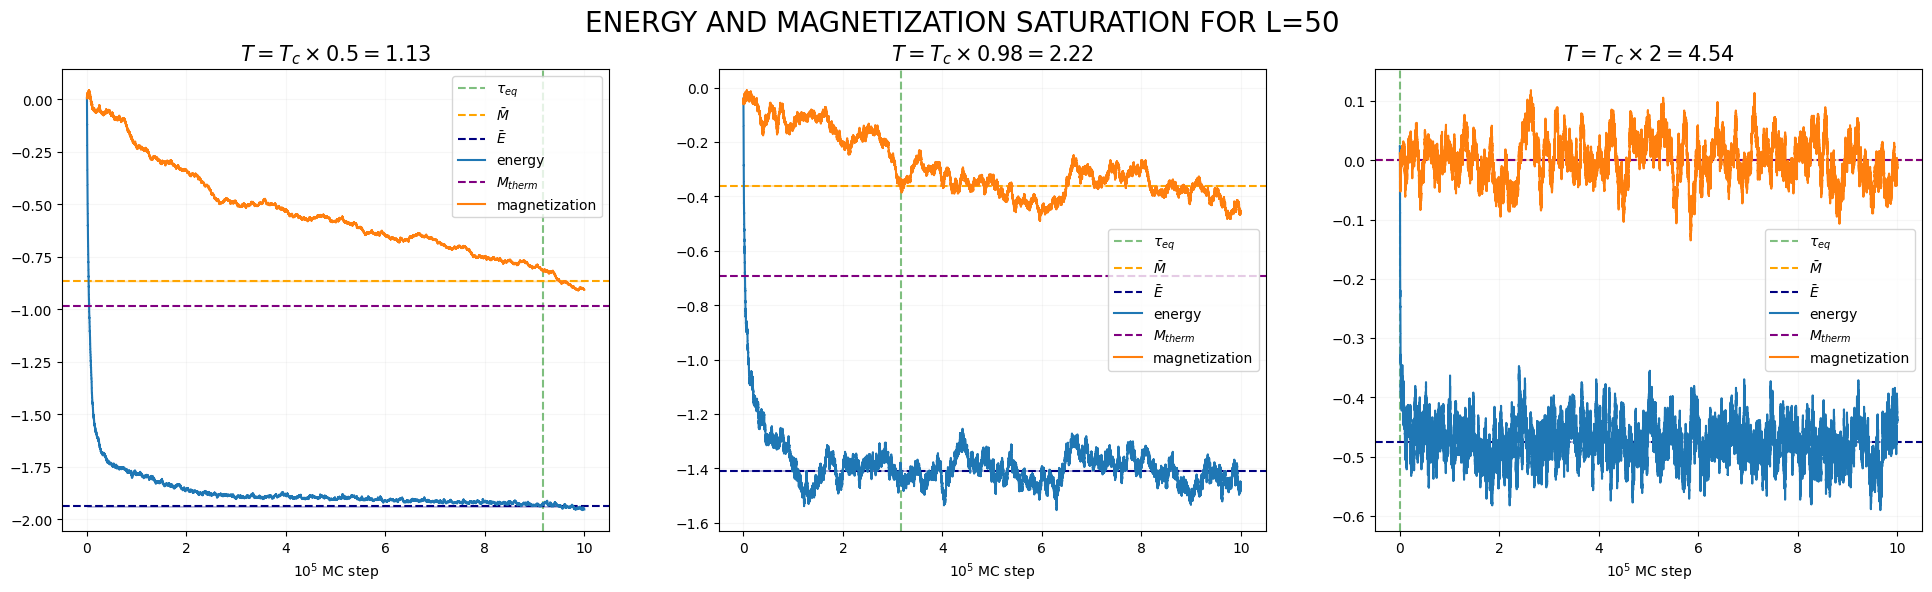

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=len(L_range),figsize=(24,6))
L = L_range[1]
plt.suptitle("ENERGY AND MAGNETIZATION SATURATION FOR L={}".format(L), fontsize=20)
for j, T in enumerate(T_range):
    
    M = get_collection(magnetizations, np.around(T,2), L)
    E = get_collection(energies, np.around(T,2), L)
    x_range = [i/10**5 for i in range(E.shape[0])]
    
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, int(len(x_range)/10))
    display(Math(r"T={:.2f}: \tau_{{eq}}={}, \bar{{E}} = {:.5f} \pm {:.5f}, \bar{{M}} = {:.5f} \pm {:.5f}, C_V = {:.5f}, \chi = {:.5f}".format(T, t_eq, avg_E, sigma_E, avg_M, sigma_M, specific_heat, magnetic_susceptibility)))   
    ax[j].axvline(t_eq/10**5, label=r"$\tau_{eq}$", color="green", linestyle="--", alpha=0.5)
    ax[j].axhline(avg_M, label=r"$\bar{{M}}$", color="orange", linestyle="--")
    ax[j].fill_between(x_range, avg_M - sigma_M, avg_M + sigma_M, color="orange", alpha=0.3)
    ax[j].axhline(avg_E, label=r"$\bar{{E}}$", color="navy", linestyle="--")
    ax[j].fill_between(x_range, avg_E - sigma_E, avg_E + sigma_E, color="navy", alpha=0.3)
        
    ax[j].plot(x_range, E, label="energy")
    ax[j].axhline(M_lim[j]*np.sign(M[-1]), label=r"$M_{therm}$", color="purple", linestyle="--")
    ax[j].plot(x_range, M, label="magnetization")

    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    
plt.show()

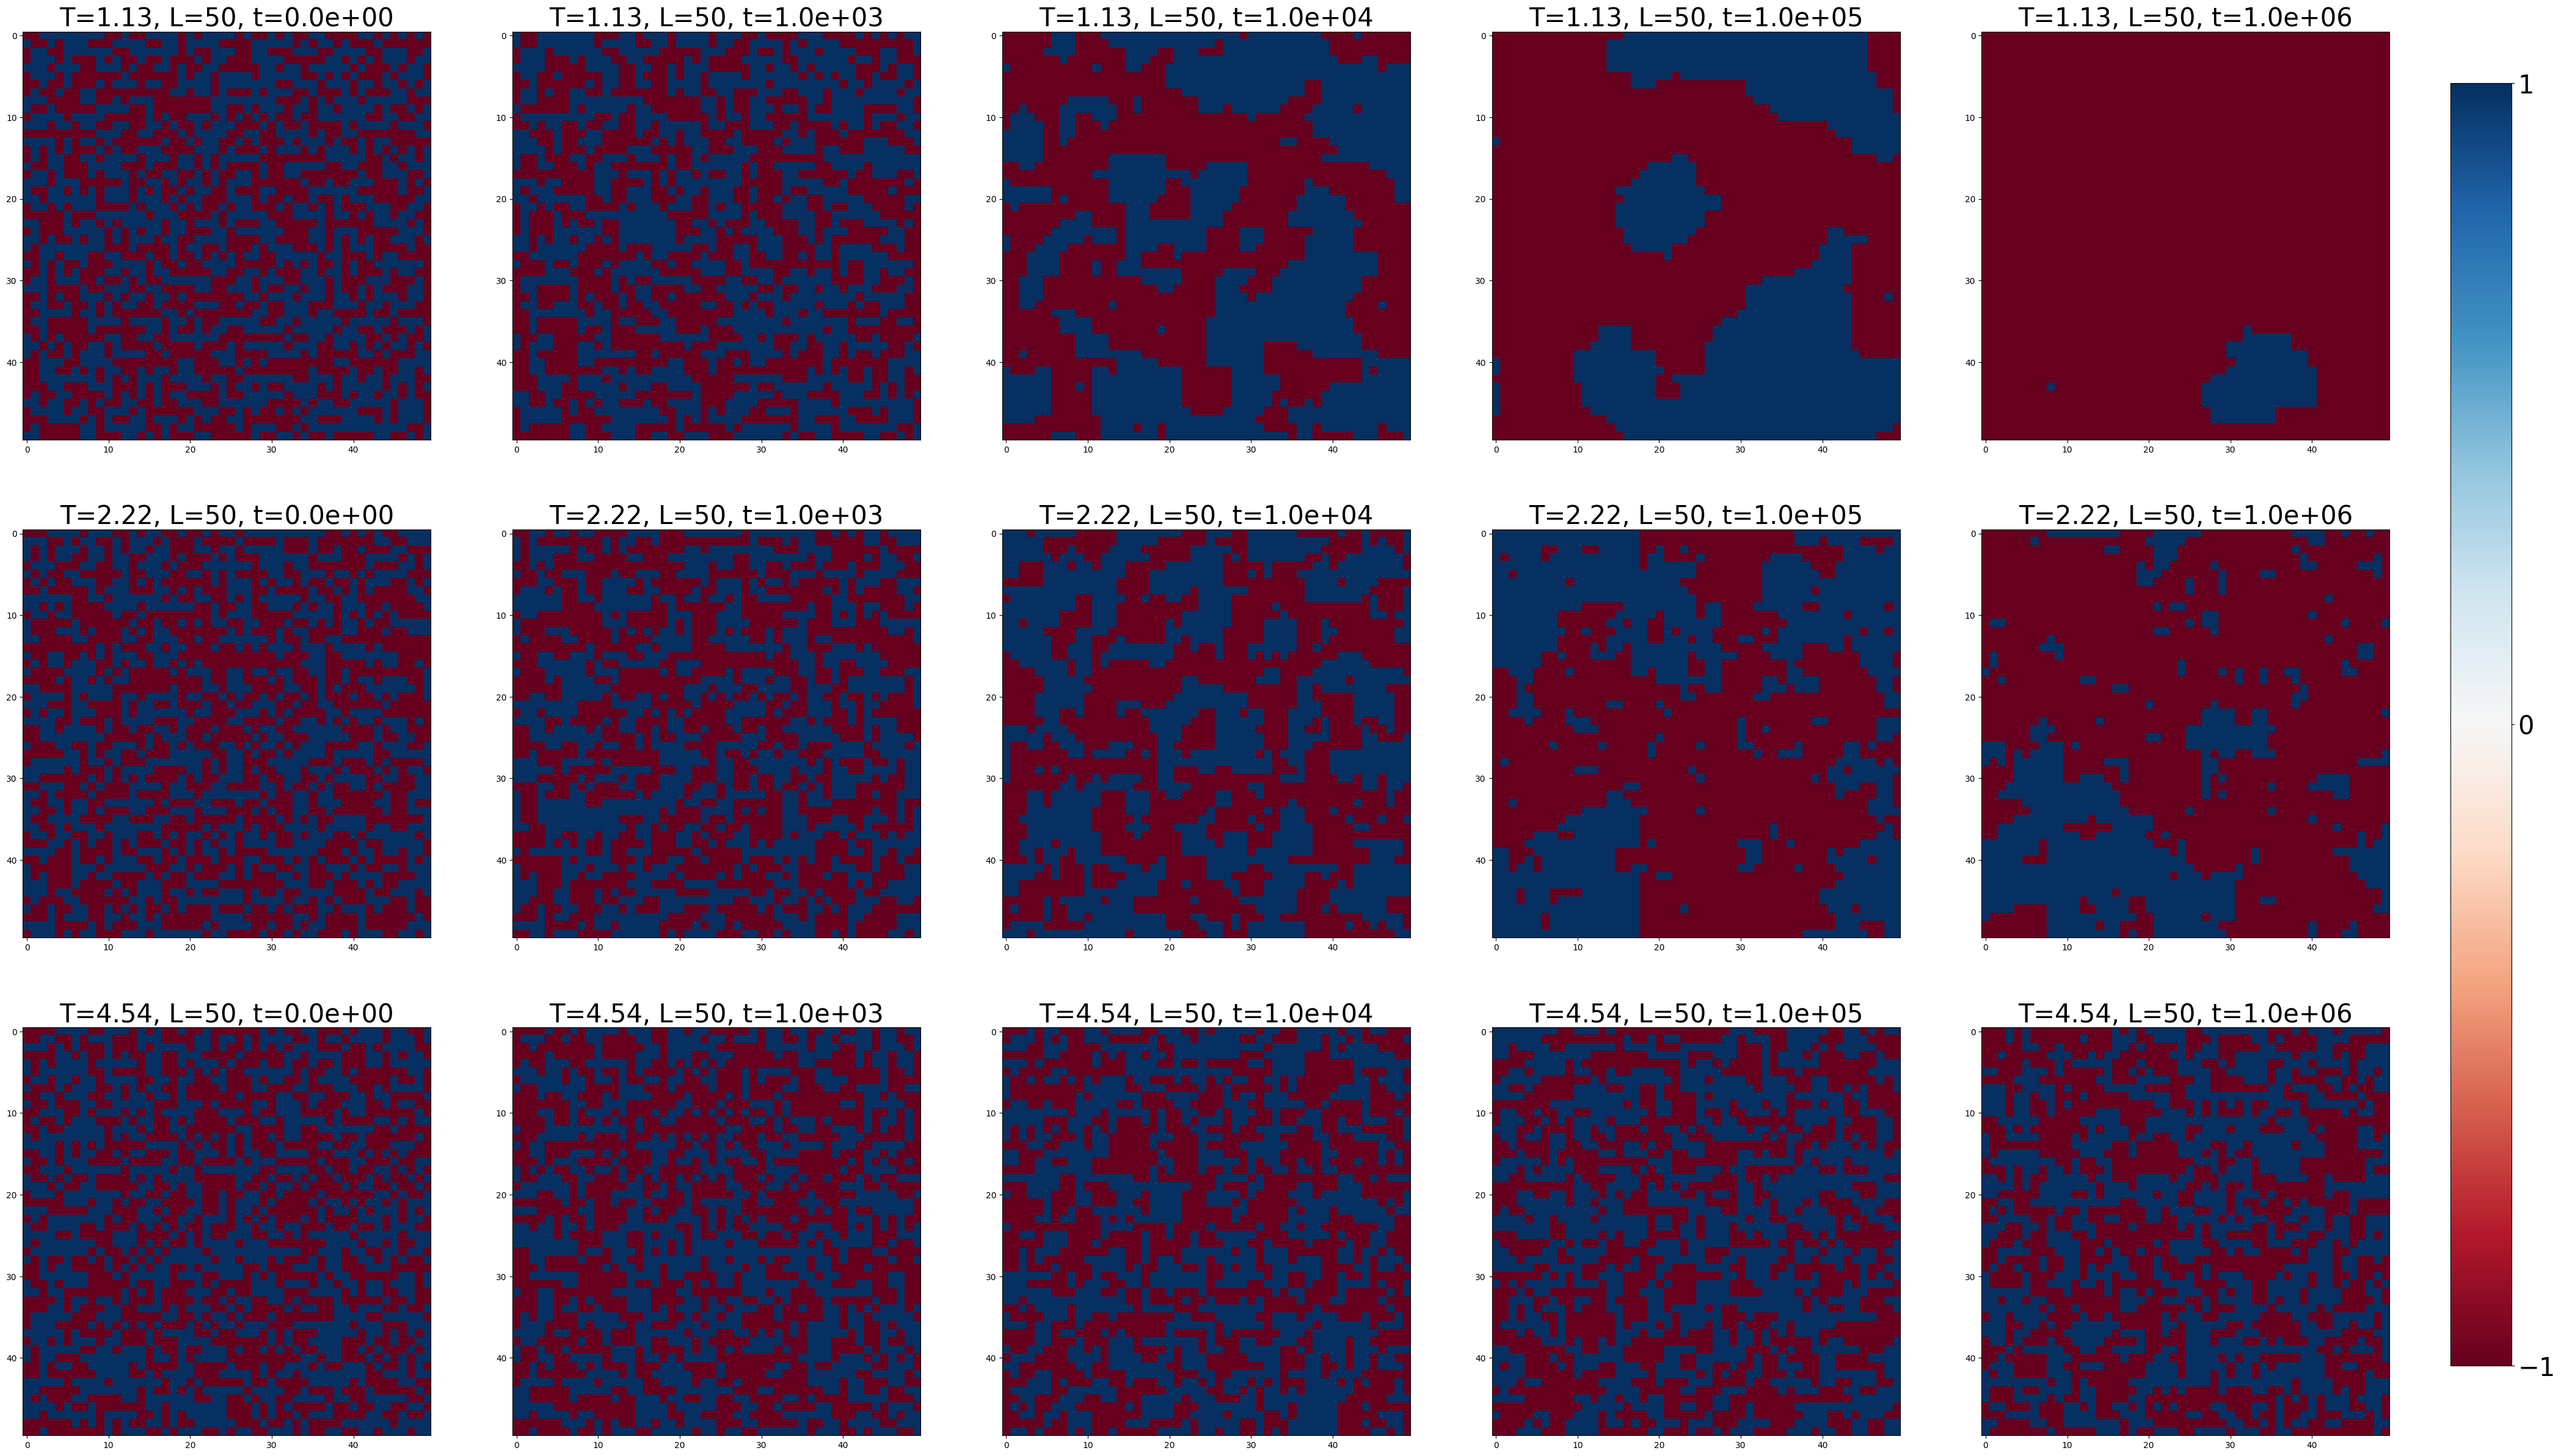

In [16]:
cmap = plt.get_cmap('RdBu') 
t_range = i_range_tot[1]
L_mesh, i_mesh = np.meshgrid(L_range, t_range, indexing='ij')
fig, ax = plt.subplots(nrows=len(T_range), ncols=len(t_range),figsize=(len(t_range)*10,10*len(T_range)))
for j, T in enumerate(T_range):
    for k, t in enumerate(t_range):
        matrix = get_matrix(spins, np.around(T,2), L, t)
        im = ax[j][k].imshow(matrix, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
        ax[j][k].set_title("T={:.2f}, L={}, t={:.1e}".format(T, L, t), fontsize=30)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=30) 
plt.show()

## **L=100**

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

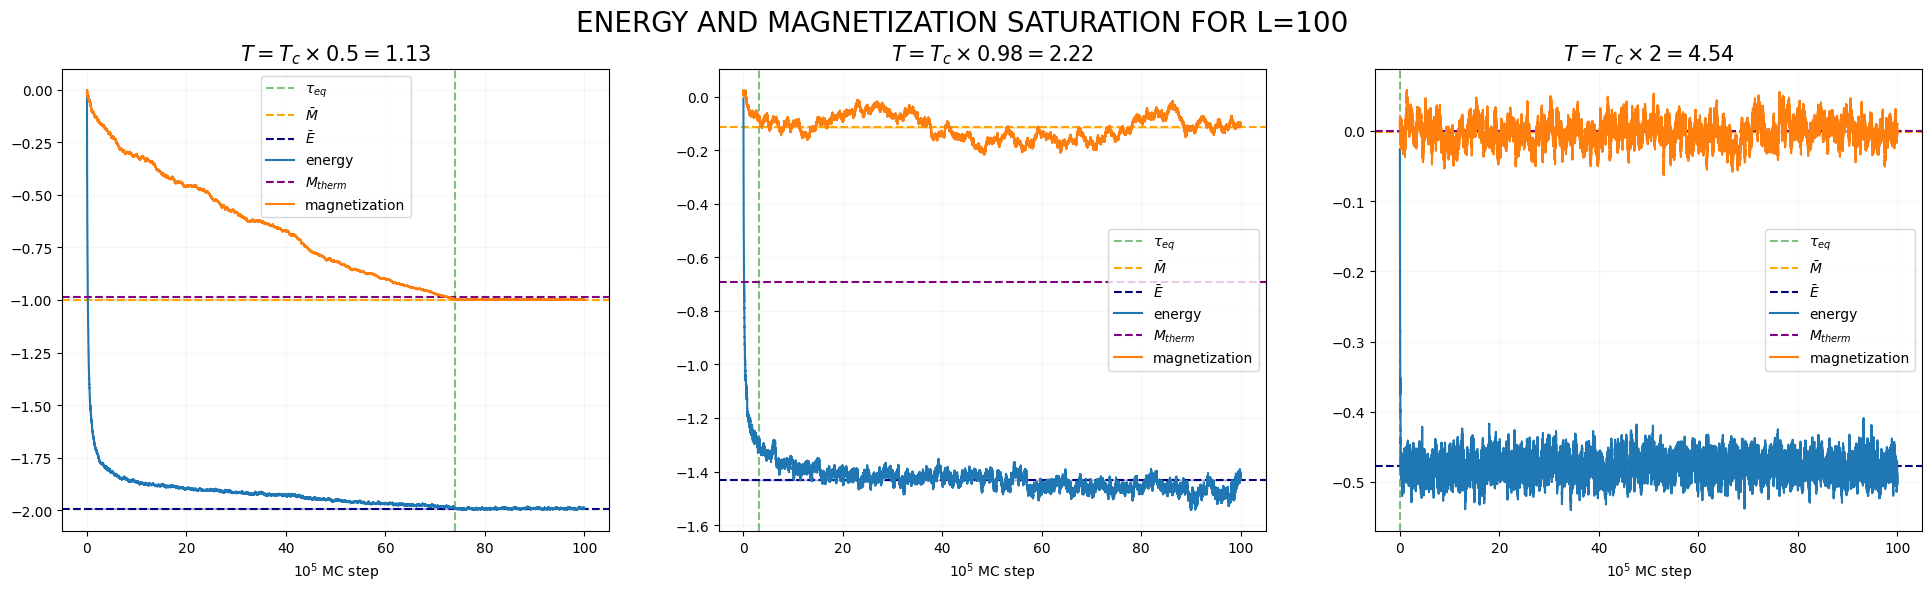

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=len(L_range),figsize=(24,6))
L = L_range[2]
plt.suptitle("ENERGY AND MAGNETIZATION SATURATION FOR L={}".format(L), fontsize=20)
for j, T in enumerate(T_range):
    
    M = get_collection(magnetizations, np.around(T,2), L)
    E = get_collection(energies, np.around(T,2), L)
    x_range = [i/10**5 for i in range(E.shape[0])]
    
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, int(len(x_range)/10))
    display(Math(r"T={:.2f}: \tau_{{eq}}={}, \bar{{E}} = {:.5f} \pm {:.5f}, \bar{{M}} = {:.5f} \pm {:.5f}, C_V = {:.5f}, \chi = {:.5f}".format(T, t_eq, avg_E, sigma_E, avg_M, sigma_M, specific_heat, magnetic_susceptibility)))   
    ax[j].axvline(t_eq/10**5, label=r"$\tau_{eq}$", color="green", linestyle="--", alpha=0.5)
    ax[j].axhline(avg_M, label=r"$\bar{{M}}$", color="orange", linestyle="--")
    ax[j].fill_between(x_range, avg_M - sigma_M, avg_M + sigma_M, color="orange", alpha=0.3)
    ax[j].axhline(avg_E, label=r"$\bar{{E}}$", color="navy", linestyle="--")
    ax[j].fill_between(x_range, avg_E - sigma_E, avg_E + sigma_E, color="navy", alpha=0.3)
        
    ax[j].plot(x_range, E, label="energy")
    ax[j].axhline(M_lim[j]*np.sign(M[-1]), label=r"$M_{therm}$", color="purple", linestyle="--")
    ax[j].plot(x_range, M, label="magnetization")

    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    ax[j].set_title(r"$T=T_c \times {}={:.2f}$".format(labels[j],T),fontsize=15)
    ax[j].set_xlabel(r"$10^5$ MC step")
    ax[j].legend(loc="best")
    ax[j].grid(alpha=0.1)
    
plt.show()

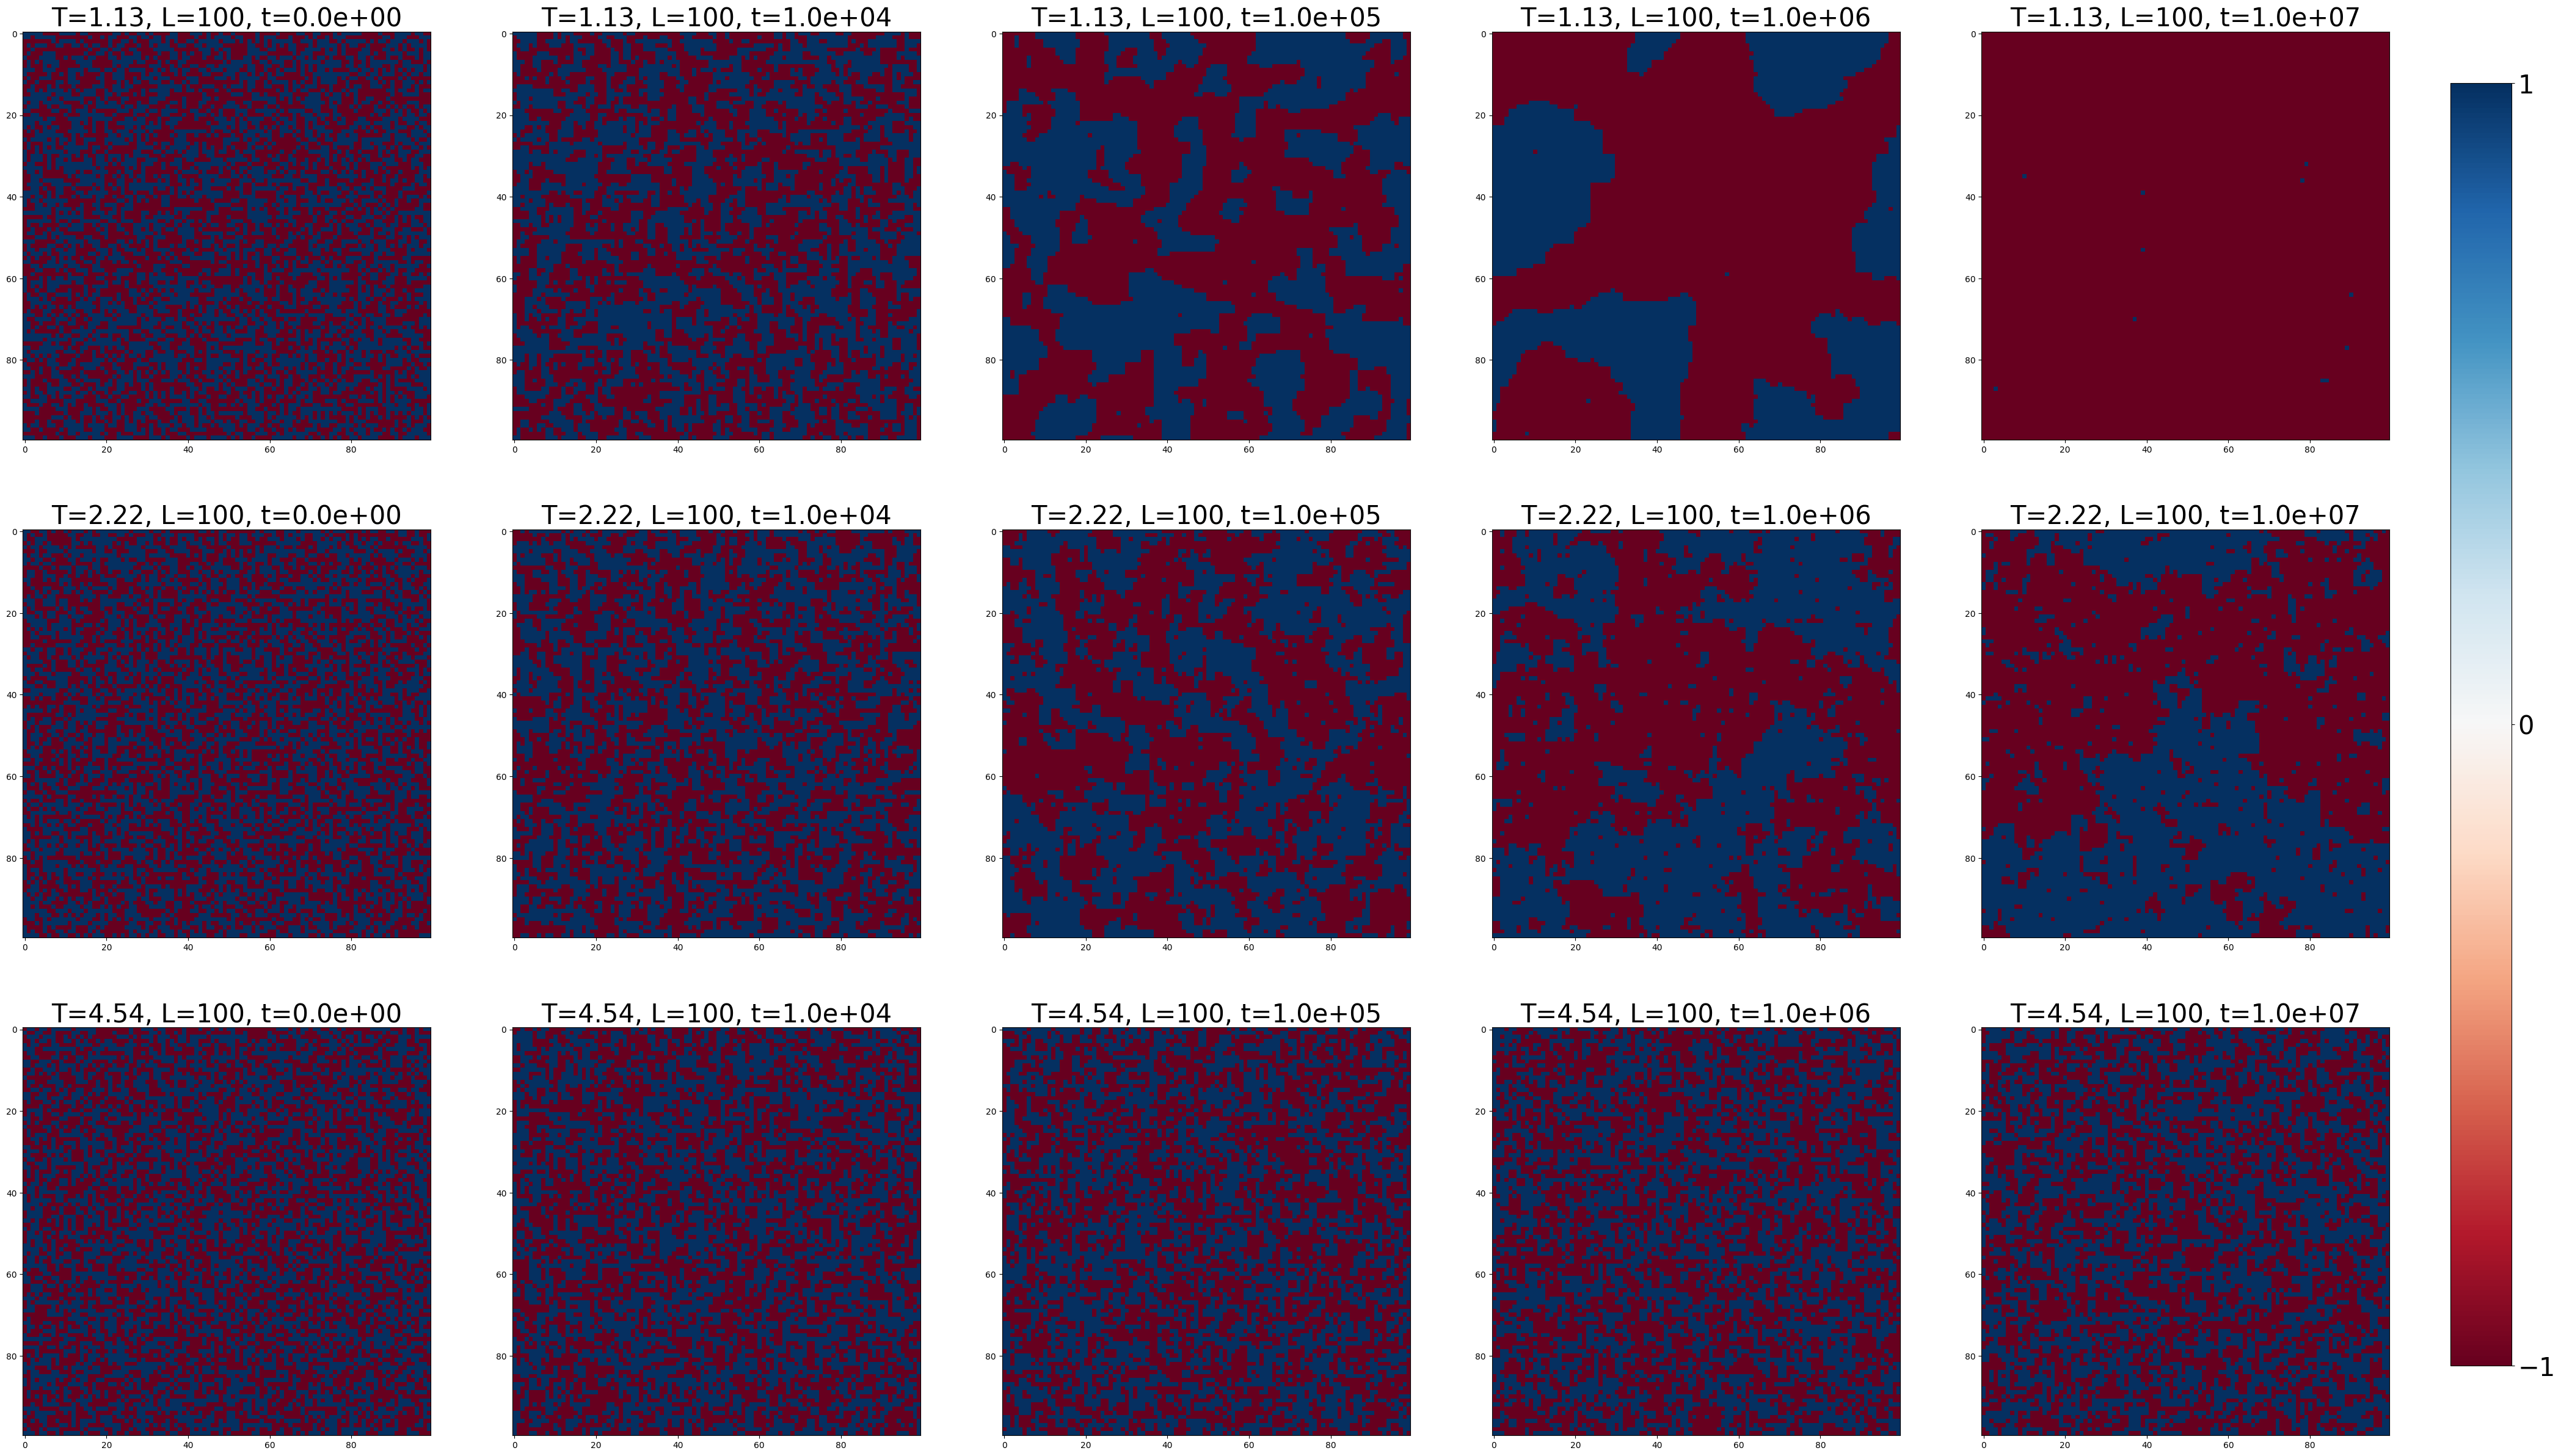

In [18]:
cmap = plt.get_cmap('RdBu') 
t_range = i_range_tot[2]
L_mesh, i_mesh = np.meshgrid(L_range, t_range, indexing='ij')
fig, ax = plt.subplots(nrows=len(T_range), ncols=len(t_range),figsize=(len(t_range)*10,10*len(T_range)))
for j, T in enumerate(T_range):
    for k, t in enumerate(t_range):
        matrix = get_matrix(spins, np.around(T,2), L, t)
        im = ax[j][k].imshow(matrix, cmap=cmap, interpolation='nearest', vmin=-1, vmax=1)
        ax[j][k].set_title("T={:.2f}, L={}, t={:.1e}".format(T, L, t), fontsize=30)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = plt.colorbar(im, cax=cbar_ax, ticks=[-1, 0, 1])
cbar.ax.tick_params(labelsize=30) 
plt.show()

## 5.2 Exercise

**Integrated correlation time and critical slowing-down** Estimate the autocorrelation time of the magnetisation and the energy for the MC simulations proposed above and estimate the errors accordingly.

<br>

**Finite-size analysis and estimates of the critical exponents** By following the procedure sketched in section 2.9 and in the lecture perform a finite size scaling analysis of the specific heat, the magnetisation and the magnetic susceptibility for the 2D Ising model simulated above. Provide a first estimate of the $\gamma$ and $\beta$ exponents.

CPU times: total: 26.3 s
Wall time: 34.4 s


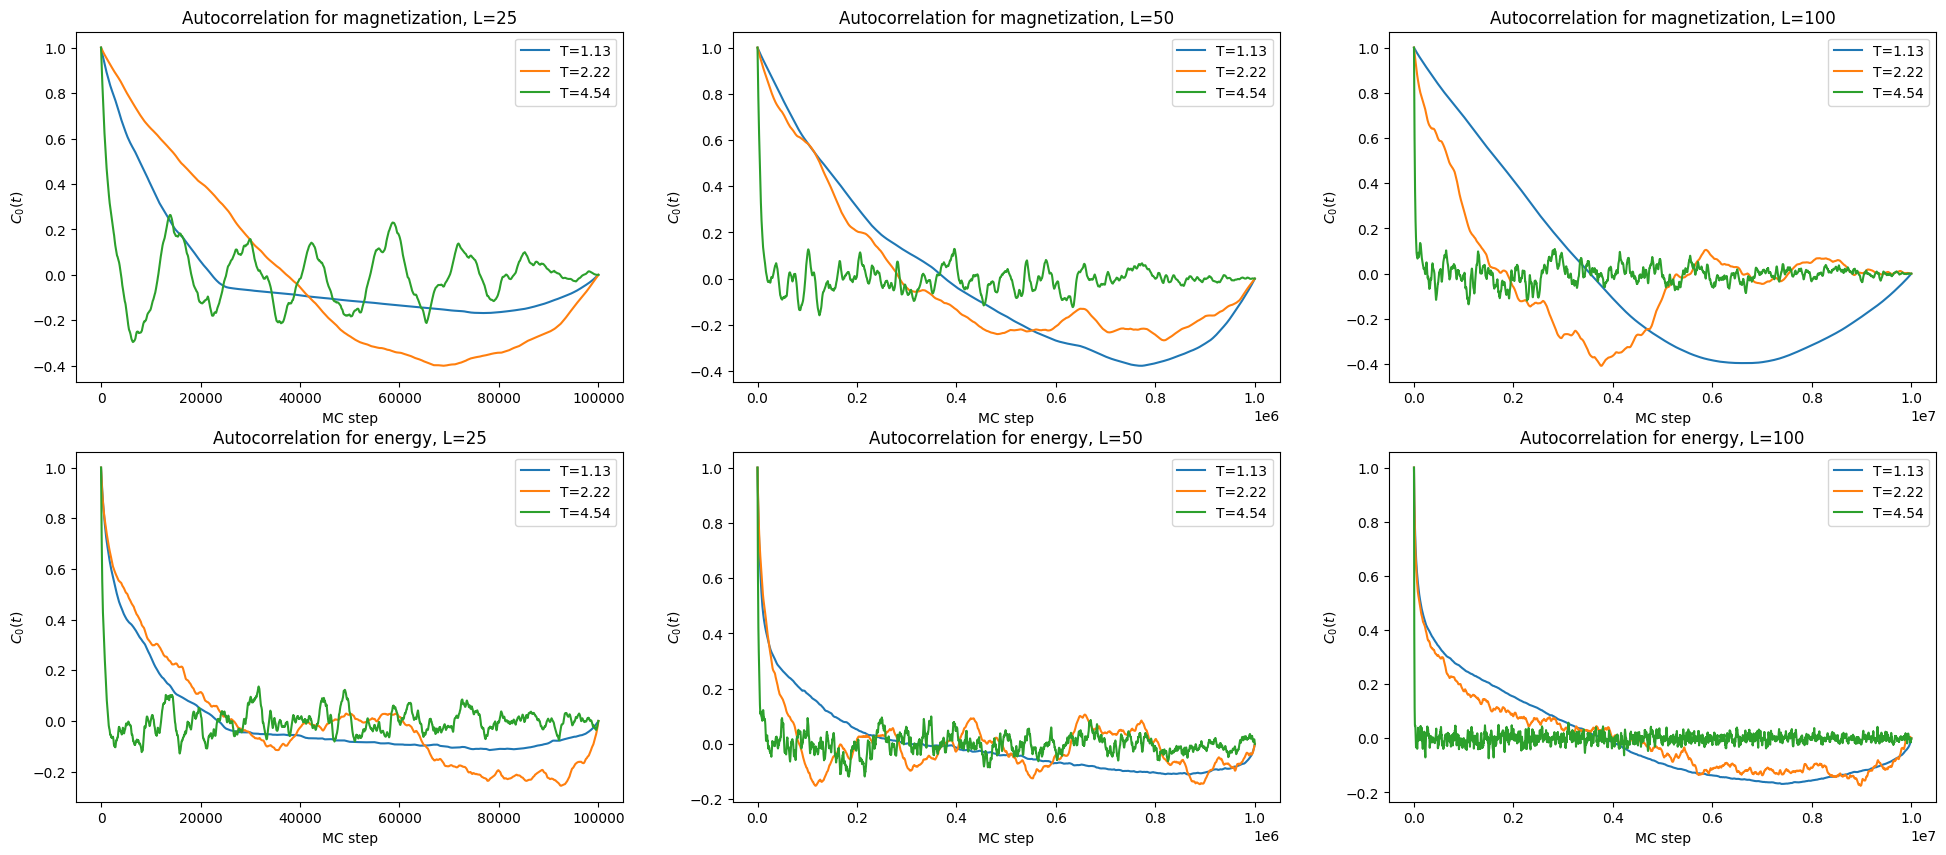

In [5]:
%%time
import statsmodels.api as sm
fig, ax = plt.subplots(nrows=2, ncols=len(L_range),figsize=(24,10))

# save autocorrelation values of M and E for every L and T
C_M = {}
C_E = {}
for j, L in enumerate(L_range):
    for i, T in enumerate(T_range):
        M = get_collection(magnetizations, np.around(T,2), L)
        E = get_collection(energies, np.around(T,2), L)
        tmp_m = sm.tsa.acf(M, nlags = M.shape[0])
        tmp_e = sm.tsa.acf(E, nlags = E.shape[0])
        C_M[(T, L)] = np.array(tmp_m)
        C_E[(T, L)] = np.array(tmp_e)
        ax[0][j].plot(range(len(tmp_m)), tmp_m, label="T={:.2f}".format(T))
        ax[0][j].set_xlabel("MC step")
        ax[0][j].set_ylabel(r"$C_0(t)$")
        ax[0][j].set_title("Autocorrelation for magnetization, L={}".format(L))
        ax[0][j].legend()
        ax[1][j].plot(range(len(tmp_e)), tmp_e, label="T={:.2f}".format(T))
        ax[1][j].set_xlabel("MC step")
        ax[1][j].set_ylabel(r"$C_0(t)$")
        ax[1][j].set_title("Autocorrelation for energy, L={}".format(L))
        ax[1][j].legend()

In [6]:
from scipy.optimize import curve_fit

def fit_exp(x, a, tau0):
    return a*np.exp(-x/tau0)

def var_autoc(tau, A, avgA):
    a = (1+2*tau)/(A.shape[0]-1)
    return a*np.sum(np.abs(A-avgA))
    
tau_M = []
tau_E = []
x_range = [10**5, 10**6, 10**7]
for j, L in enumerate(L_range):
    for i, T in enumerate(T_range):
        M_corr = get_collection(C_M, T, L)
        E_corr = get_collection(C_E, T, L)
        M = get_collection(magnetizations, np.around(T,2), L)
        E = get_collection(energies, np.around(T,2), L)
        t_eq, avg_M, sigma_M, avg_E, sigma_E, _, _ = equilibrium_stat(M, E, T, L, int(M.shape[0]/10))
        params_M, errs_M = curve_fit(fit_exp, np.array(range(x_range[j]+1)), M_corr)
        params_E, errs_E = curve_fit(fit_exp, np.array(range(x_range[j]+1)), E_corr)
        tau = params_M[1] if params_M[1] > params_E[1] else params_E[1]
        true_sigma_M = np.sqrt(var_autoc(tau, M, avg_M)/M.shape[0])
        true_sigma_E = np.sqrt(var_autoc(tau, E, avg_E)/E.shape[0])
        display(Math(r"L = {}, \quad T = {:.2f}".format(L,T)))
        display(Math(r"\tau_0^M={} \pm {} \quad \tau_0^E={} \pm {} \rightarrow \tau_0={} \quad  n_{{uncor}} ={}".format(int(params_M[1]),int(np.sqrt(errs_M[1][1])), int(params_E[1]),int(np.sqrt(errs_E[1][1])), int(tau), int(x_range[j]/tau))))
        display(Math(r"\bar{{M}} = {:.3f} \pm {:.3f} \quad \text{{previous }}\sigma:{:.5f}, \quad \bar{{E}} = {:.3f} \pm {:.3f} \quad \text{{previous }}\sigma:{:.5f}".format(avg_M, true_sigma_M, sigma_M, avg_E, true_sigma_E, sigma_M)))
        print("--------------")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

--------------


### Finite scale analysis

In order to avoid long computational time, the L that we will use to find as first reference is $L=5$

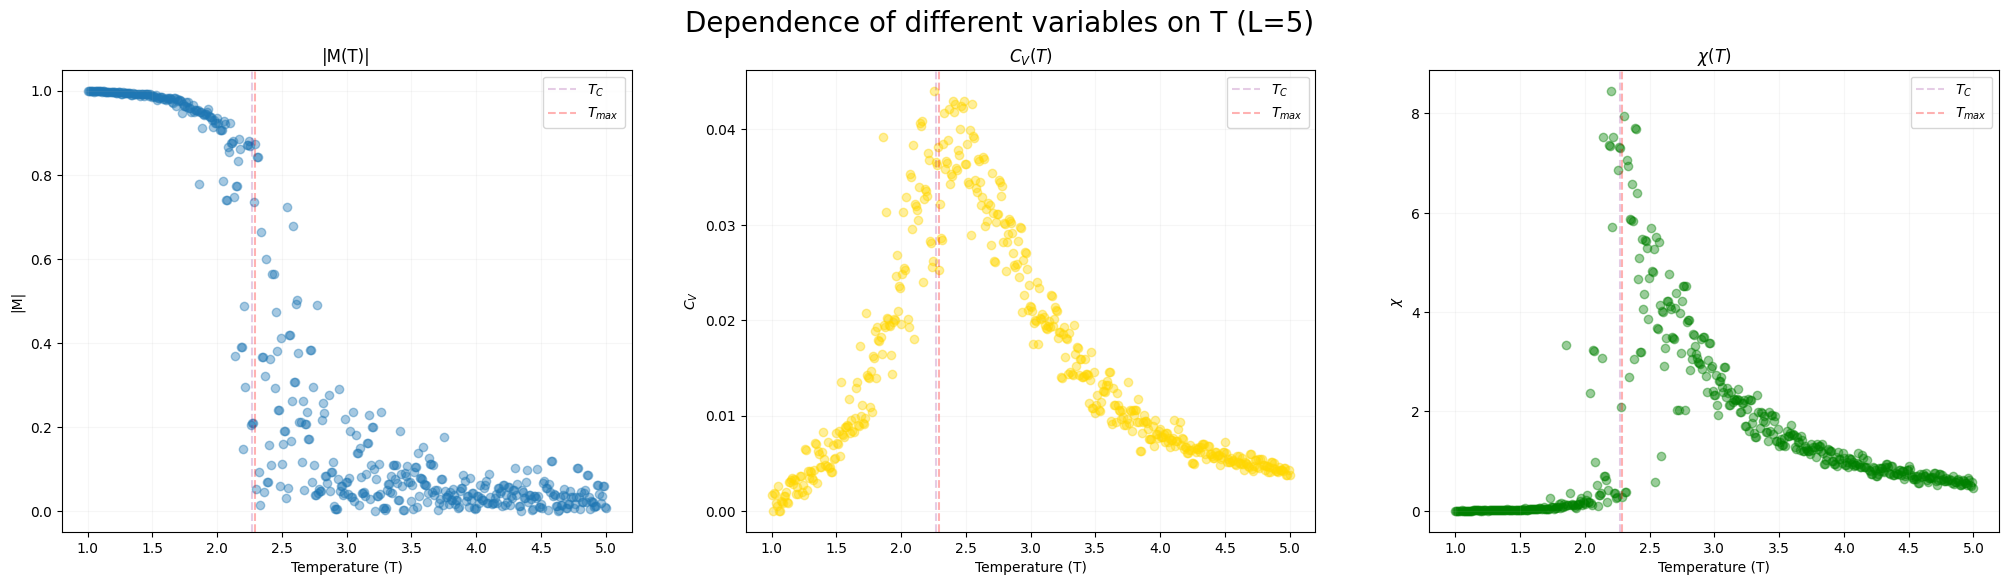

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
plt.suptitle("Dependence of different variables on T (L=5)", fontsize=20)
L = 5
# define the step increment
N_points = 500
T_range_finite = np.linspace(1,5,N_points)
magn_L10 = load_from_file('magnetizations_finite_scale.txt')
en_L10 = load_from_file('energies_finite_scale.txt')
CV = []
Chi = []
M_coll = []
for i, T in enumerate(T_range_finite):
    M = get_collection(magn_L10, np.around(T,2), L)
    E = get_collection(en_L10, np.around(T,2), L)
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, 1000) 
    CV.append(specific_heat)
    Chi.append(magnetic_susceptibility)
    M_coll.append(avg_M)

idx_max = np.where(np.array(CV)==max(CV))[0][0]
T_max = T_range_finite[idx_max1]

ax[0].scatter(T_range_finite, np.abs(np.array(M_coll)), alpha = 0.4)
ax[0].set_ylabel("|M|")
ax[0].set_title("|M(T)|")
ax[1].scatter(T_range_finite, np.array(CV), alpha = 0.4, color="gold")
ax[1].set_ylabel(r"$C_V$")
ax[1].set_title(r"$C_V(T)$")
ax[2].scatter(T_range_finite, np.array(Chi), alpha = 0.4, color="green")
ax[2].set_ylabel(r"$\chi$")
ax[2].set_title(r"$\chi(T)$")
for j in range(3):
    ax[j].set_xlabel("Temperature (T)")
    ax[j].grid(alpha=0.1)
    ax[j].axvline(T_C, label=r"$T_C$", alpha=0.2, linestyle="--", color="purple")
    ax[j].axvline(T_max1, label=r"$T_{max}$", alpha=0.3, linestyle="--", color="red")
    ax[j].legend()


In [54]:
N_points = 5
np.array([int(i) for i in np.linspace(5,20,N_points)])

array([ 5,  8, 12, 16, 20])

correlation score 1: 0.8857295116437607
beta/nu:  1.7135754958265101
correlation score 2: 0.9636953287299475
alpha/nu:  -4.012404349176613
correlation score 3: 0.5185881126650156
gamma/nu:  -1.989863057761448


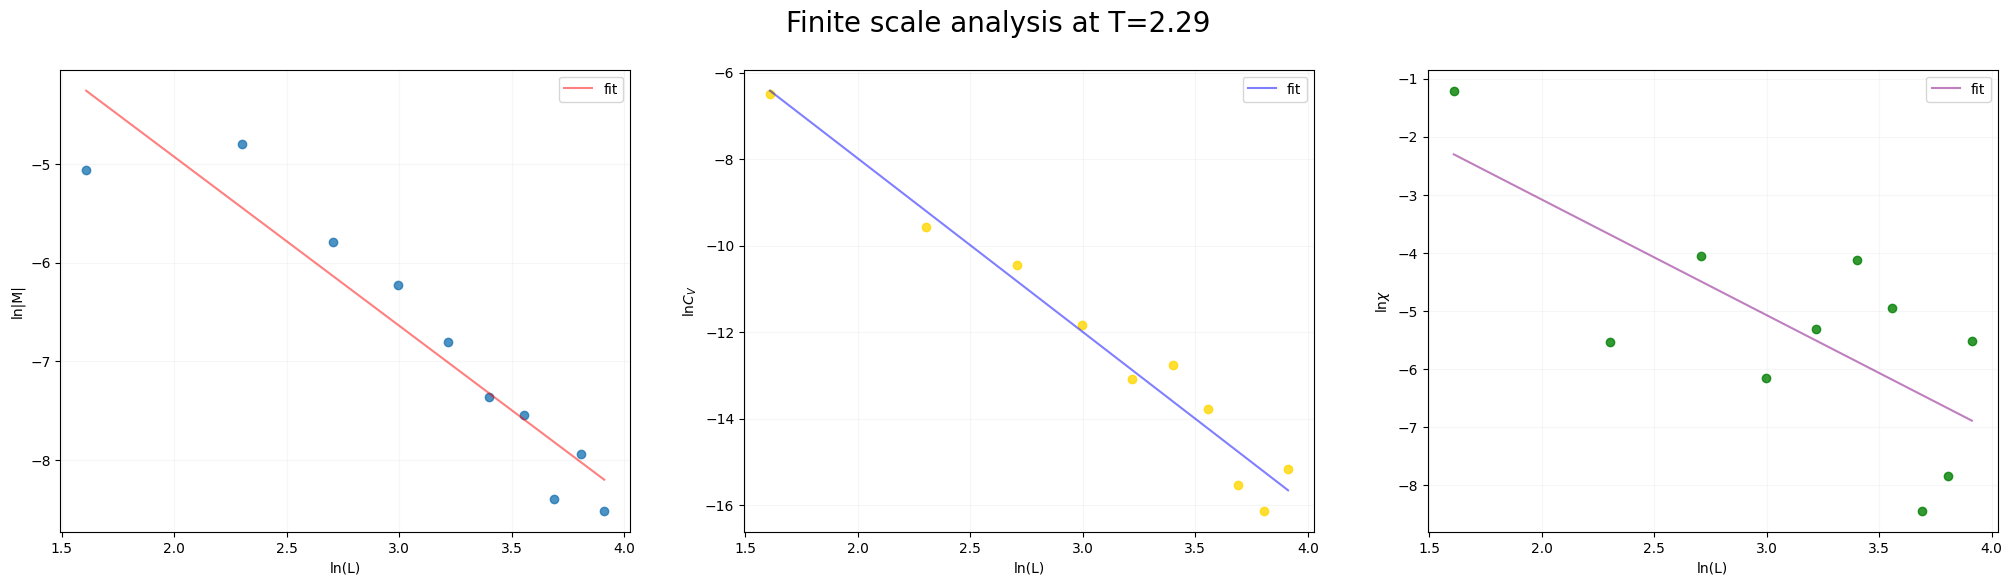

In [53]:
from sklearn.linear_model import LinearRegression
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
plt.suptitle("Finite scale analysis at T=2.29", fontsize=20)
T = 2.27 # T_max
# define the step increment
N_points = 10
#L_range_finite = np.linspace(5,40,N_points)
L_range_finite = np.array([int(i) for i in np.linspace(5,50,N_points)])
magn_T = load_from_file('magnetizations_finite_scale_L.txt')
en_T = load_from_file('energies_finite_scale_L.txt')
CV = []
Chi = []
M_coll = []
for i, L in enumerate(L_range_finite):
    M = get_collection(magn_T, np.around(T,2), L)
    E = get_collection(en_T, np.around(T,2), L)
    t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, 1000) 
    CV.append(specific_heat/(L*L))
    Chi.append(magnetic_susceptibility/(L*L))
    M_coll.append(avg_M/(L*L))

L_log = np.log(L_range_finite).reshape(-1,1)
M_log = np.log(np.abs(np.array(M_coll))).reshape(-1,1)
ax[0].scatter(L_log, M_log, alpha = 0.8)
ax[0].set_ylabel("ln|M|")
reg1 = LinearRegression().fit(L_log, M_log)
print("correlation score 1:",reg1.score(L_log, M_log))
beta_nu = -reg1.coef_[0][0]
print("beta/nu: ",beta_nu)
y_1 = reg1.coef_*L_log+reg1.intercept_
ax[0].plot(L_log, y_1, label="fit", color="red", alpha=0.5)
#ax[0].set_title("|M(T)|")

CV_log = np.log(np.array(CV)).reshape(-1,1)
ax[1].scatter(L_log, CV_log, alpha = 0.8, color="gold")
ax[1].set_ylabel(r"ln$C_V$")
reg2 = LinearRegression().fit(L_log, CV_log)
print("correlation score 2:",reg2.score(L_log, CV_log))
alpha_nu = reg2.coef_[0][0]
print("alpha/nu: ",alpha_nu)
y_2 = reg2.coef_*L_log+reg2.intercept_
ax[1].plot(L_log, y_2, label="fit", color="blue", alpha=0.5)
#ax[1].set_title(r"$C_V(T)$")

chi_log = np.log(np.array(Chi)).reshape(-1,1)
ax[2].scatter(L_log, chi_log, alpha = 0.8, color="green")
ax[2].set_ylabel(r"ln$\chi$")
reg3 = LinearRegression().fit(L_log, chi_log)
print("correlation score 3:",reg3.score(L_log, chi_log))
gamma_nu = reg3.coef_[0][0]
print("gamma/nu: ",gamma_nu)
y_3 = reg3.coef_*L_log+reg3.intercept_
ax[2].plot(L_log, y_3, label="fit", color="purple", alpha=0.5)
#ax[2].set_title(r"$\chi(T)$")

for j in range(3):
    ax[j].set_xlabel("ln(L)")
    ax[j].grid(alpha=0.1)
    #ax[j].axvline(T_C, label=r"$T_C$", alpha=0.2, linestyle="--", color="purple")
    #ax[j].axvline(T_max1, label=r"$T_{max}$", alpha=0.3, linestyle="--", color="red")
    ax[j].legend()

In [141]:
np.array([int(i) for i in np.linspace(25,50,6)])

array([25, 30, 35, 40, 45, 50])

In [67]:
# define the step increment
N_temp = 100
T_range_finite = np.linspace(1,5,N_temp)
# compute the thermodynamic limit of magnetization as comparison with experimental results
M_lim_finite = [(1 - (1 / np.sinh(2 / T))**2)**(1/8) if T < T_C else 0 for T in T_range_finite]
N_size = 5
L_range_finite = np.array([int(i) for i in np.linspace(5,10,N_size)])
# L_range_finite = np.array([int(i) for i in np.linspace(25,50,6)])
magn_new = load_from_file('try_M.txt')
en_new = load_from_file('try_E.txt')
CV = np.zeros(shape=(N_temp, N_size))
Chi = np.zeros(shape=(N_temp, N_size))
M_coll = np.zeros(shape=(N_temp, N_size))
for i, L in enumerate(L_range_finite):
    for j, T in enumerate(T_range_finite):
        M = get_collection(magn_new, np.around(T,2), L)
        E = get_collection(en_new, np.around(T,2), L)
        t_eq, avg_M, sigma_M, avg_E, sigma_E, specific_heat, magnetic_susceptibility = equilibrium_stat(M, E, T, L, int(M.shape[0]/10)) 
        CV[j][i]= specific_heat
        Chi[j][i] = magnetic_susceptibility
        M_coll[j][i] = avg_M
        if T < T_C:
            if avg_M < M_lim_finite[j]:
                CV[j][i]= None
                Chi[j][i] = None 
                M_coll[j][i] = None

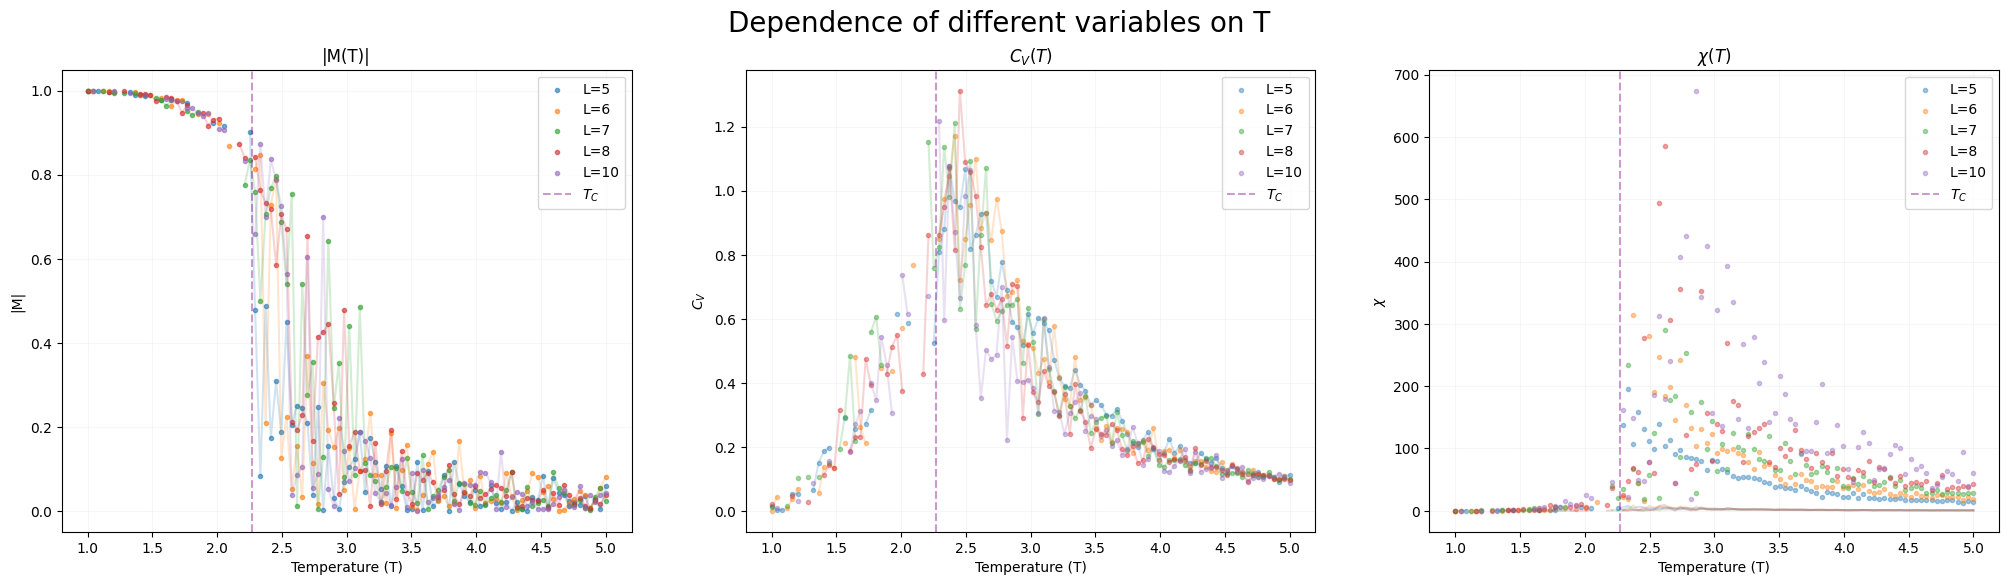

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25,6))
plt.suptitle("Dependence of different variables on T", fontsize=20)

for i, L in enumerate(L_range_finite):
    ax[0].scatter(T_range_finite, np.abs(np.array(M_coll[:,i])), alpha = 0.6, label="L={}".format(L), marker=".")
    ax[0].plot(T_range_finite, np.abs(np.array(M_coll[:,i])), alpha = 0.2)
    ax[0].set_ylabel("|M|")
    ax[0].set_title("|M(T)|")
    ax[1].scatter(T_range_finite, np.array(CV[:,i]*L*L), alpha = 0.4, label="L={}".format(L), marker=".")
    ax[1].plot(T_range_finite, np.array(CV[:,i]*L*L), alpha = 0.2)
    ax[1].set_ylabel(r"$C_V$")
    ax[1].set_title(r"$C_V(T)$")
    ax[2].scatter(T_range_finite, np.array(Chi[:,i]*L*L), alpha = 0.4, label="L={}".format(L), marker=".")
    ax[2].plot(T_range_finite, np.array(Chi[:,i]), alpha = 0.2)
    ax[2].set_ylabel(r"$\chi$")
    ax[2].set_title(r"$\chi(T)$")

#ax[0].plot(T_range_finite, M_lim_finite, label=r"$M_{lim}$")
    
for j in range(3):
    ax[j].set_xlabel("Temperature (T)")
    ax[j].grid(alpha=0.1)
    ax[j].axvline(T_C, label=r"$T_C$", alpha=0.4, linestyle="--", color="purple")
    #ax[j].axvline(T_max[i], label=r"$T_{max}$", alpha=0.3, linestyle="--", color="red")
    ax[j].legend()


In [75]:
# for each L we find T_max by looking at the max value of CV
CV_max = np.nanmax(CV, axis=0)
T_idx, L_idx = np.where(CV==CV_max)
T_max = np.zeros(shape=(N_size,1))
M_L = np.zeros(shape=(N_size,1))
CV_L = np.zeros(shape=(N_size,1))
chi_L = np.zeros(shape=(N_size,1))
for k, index in enumerate(L_idx):
    T_max[index] = T_range_finite[T_idx[k]]
    M_L[index] = M_coll[T_idx[k]][index]
    CV_L[index] = CV[T_idx[k]][index]
    chi_L[index] = Chi[T_idx[k]][index]

correlation score 0: 0.9094414222628799
nu:  -0.2994870718773101
correlation score 1: 0.13122014994790987
beta/nu:  -0.24892342397417092 beta = 0.07454934736769867
correlation score 2: 0.9905533160189124
alpha/nu:  1.7971339944663889 alpha= -0.5382183977739128
correlation score 3: 0.06639822611790203
gamma/nu:  0.17592748804121408 gamma= -0.05268800825619369


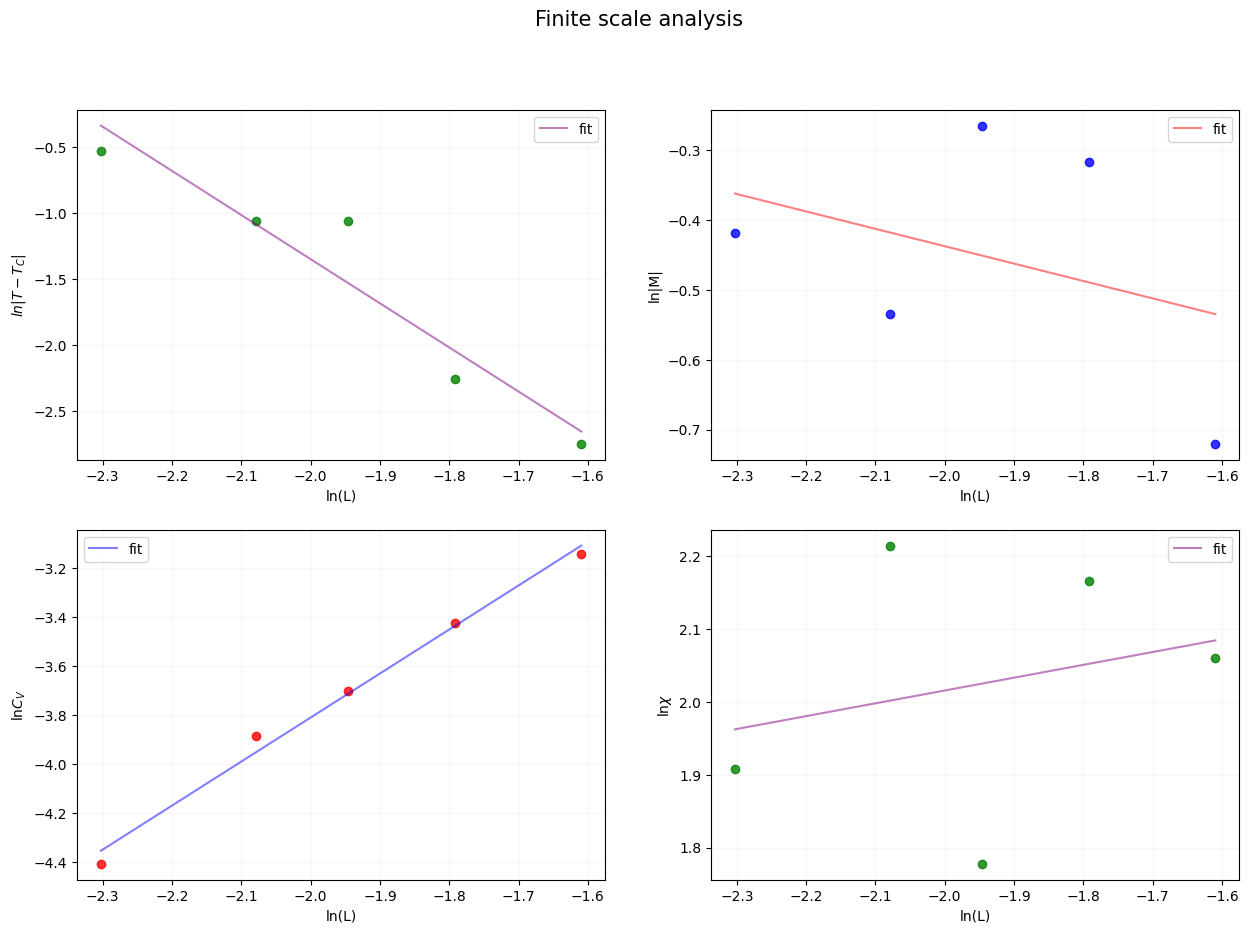

In [83]:
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
plt.suptitle("Finite scale analysis", fontsize=15)

L_log = np.log(1/L_range_finite).reshape(-1,1)
T_log = np.log(np.abs(T_max-T_C)).reshape(-1,1)
ax[0][0].scatter(L_log, T_log, alpha = 0.8, color="green")
ax[0][0].set_ylabel(r"$ln|T-T_C|$")
reg0 = LinearRegression().fit(L_log, T_log)
print("correlation score 0:",reg0.score(L_log, T_log))
nu = 1/reg0.coef_[0][0]
print("nu: ",nu)
y_0 = reg0.coef_*L_log+reg0.intercept_
ax[0][0].plot(L_log, y_0, label="fit", alpha=0.5, color="purple")
#ax[0][0].plot(L_log, -L_log+reg0.intercept_)
#ax[0].set_title("|M(T)|")


M_log = np.log(np.abs(M_L)).reshape(-1,1)
ax[0][1].scatter(L_log, M_log, alpha = 0.8, color="blue")
ax[0][1].set_ylabel("ln|M|")
reg1 = LinearRegression().fit(L_log, M_log)
print("correlation score 1:",reg1.score(L_log, M_log))
beta_nu = reg1.coef_[0][0]
print("beta/nu: ",beta_nu, "beta =",beta_nu*nu)
y_1 = reg1.coef_*L_log+reg1.intercept_
ax[0][1].plot(L_log, y_1, label="fit", color="red", alpha=0.5)
#ax[0].set_title("|M(T)|")

# for each L we find T_max by looking at the max value of CV
CV_max = np.nanmax(CV, axis=0)
T_idx, L_idx = np.where(CV==CV_max)
T_max = np.zeros(shape=(N_size,1))
CV_L = np.zeros(shape=(N_size,1))
for k, index in enumerate(L_idx):
    T_max[index] = T_range_finite[T_idx[k]]
    CV_L[index] = CV[T_idx[k]][index]

CV_log = np.log(CV_L).reshape(-1,1)
ax[1][0].scatter(L_log, CV_log, alpha = 0.8, color="red")
ax[1][0].set_ylabel(r"ln$C_V$")
reg2 = LinearRegression().fit(L_log, CV_log)
print("correlation score 2:",reg2.score(L_log, CV_log))
alpha_nu = reg2.coef_[0][0]
print("alpha/nu: ",alpha_nu, "alpha=",alpha_nu*nu)
y_2 = reg2.coef_*L_log+reg2.intercept_
ax[1][0].plot(L_log, y_2, label="fit", color="blue", alpha=0.5)
#ax[1].set_title(r"$C_V(T)$")

# for each L we find T_max by looking at the max value of CV
Chi_max = np.nanmax(Chi, axis=0)
T_idx, L_idx = np.where(Chi==Chi_max)
T_max = np.zeros(shape=(N_size,1))
chi_L = np.zeros(shape=(N_size,1))
for k, index in enumerate(L_idx):
    T_max[index] = T_range_finite[T_idx[k]]
    chi_L[index] = Chi[T_idx[k]][index]

chi_log = np.log(chi_L).reshape(-1,1)
ax[1][1].scatter(L_log, chi_log, alpha = 0.8, color="green")
ax[1][1].set_ylabel(r"ln$\chi$")
reg3 = LinearRegression().fit(L_log, chi_log)
print("correlation score 3:",reg3.score(L_log, chi_log))
gamma_nu = reg3.coef_[0][0]
print("gamma/nu: ",gamma_nu,"gamma=",gamma_nu*nu)
y_3 = reg3.coef_*L_log+reg3.intercept_
ax[1][1].plot(L_log, y_3, label="fit", color="purple", alpha=0.5)
#ax[2].set_title(r"$\chi(T)$")

for i in range(2):
    for j in range(2):
        ax[i][j].set_xlabel("ln(1/L)")
        ax[i][j].grid(alpha=0.1)
        #ax[j].axvline(T_C, label=r"$T_C$", alpha=0.2, linestyle="--", color="purple")
        #ax[j].axvline(T_max1, label=r"$T_{max}$", alpha=0.3, linestyle="--", color="red")
        ax[i][j].legend()

correlation score: 0.9999884473427673
beta/nu:  2.003869775975769


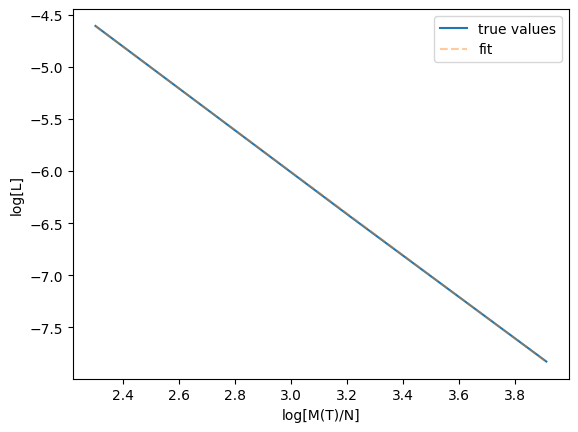

In [116]:
T
x = np.log(np.array(L_range)).reshape(-1,1)
y = np.log(np.array(M_N)).reshape(-1,1)
reg = LinearRegression().fit(x, y)
print("correlation score:",reg.score(x, y))
beta_nu = -reg.coef_[0][0]
print("beta/nu: ",beta_nu)
y_est = reg.coef_*x+reg.intercept_
plt.plot(x,y, label="true values")
plt.plot(x, y_est, linestyle="--",alpha=0.4,label="fit")
plt.xlabel("log[M(T)/N]")
plt.ylabel("log[L]")
plt.legend()

correlation score: 0.9854468666132018
gamma/nu:  9.286217773922766


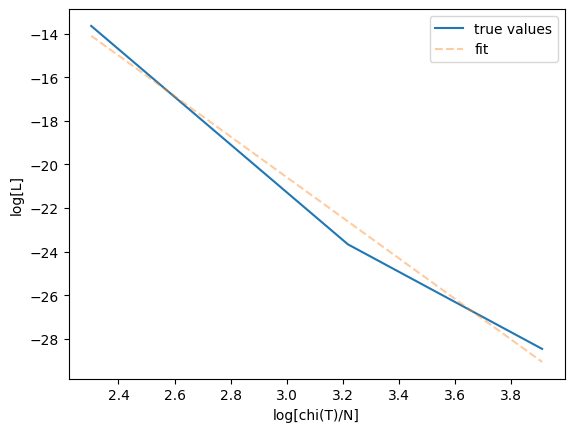

In [117]:
y = np.log(np.array(np.abs(chi))).reshape(-1,1)
reg = LinearRegression().fit(x, y)
print("correlation score:",reg.score(x, y))
gamma_nu = -reg.coef_[0][0]
print("gamma/nu: ",gamma_nu)
y_est = reg.coef_*x+reg.intercept_
plt.plot(x,y, label="true values")
plt.plot(x, y_est, linestyle="--",alpha=0.4,label="fit")
plt.xlabel("log[chi(T)/N]")
plt.ylabel("log[L]")
plt.legend()

correlation score: 0.9806473994791475
alpha/nu:  5.381797189316005


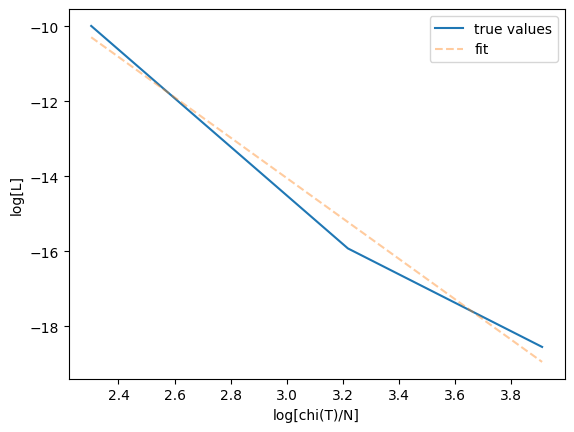

In [118]:
y = np.log(np.array(np.abs(Cv))).reshape(-1,1)
reg = LinearRegression().fit(x, y)
print("correlation score:",reg.score(x, y))
alpha_nu = -reg.coef_[0][0]
print("alpha/nu: ",alpha_nu)
y_est = reg.coef_*x+reg.intercept_
plt.plot(x,y, label="true values")
plt.plot(x, y_est, linestyle="--",alpha=0.4,label="fit")
plt.xlabel("log[chi(T)/N]")
plt.ylabel("log[L]")
plt.legend()

In [119]:
T = T_range[2]
nu1 = np.log(np.abs(T-T_C))/np.log(L_range[0])
nu2 = np.log(np.abs(T-T_C))/np.log(L_range[1])
nu3 = np.log(np.abs(T-T_C))/np.log(L_range[2])
print("For L=25:")
print("beta={}, gamma={}, alpha={}, nu={}".format(beta_nu*nu1, gamma_nu*nu1, alpha_nu*nu1, nu1))
print("For L=50:")
print("beta={}, gamma={}, alpha={}, nu={}".format(beta_nu*nu2, gamma_nu*nu2, alpha_nu*nu2, nu2))
print("For L=100:")
print("beta={}, gamma={}, alpha={}, nu={}".format(beta_nu*nu3, gamma_nu*nu3, alpha_nu*nu3, nu3))

For L=25:
beta=0.10989189249568096, gamma=0.5092546719042597, alpha=0.29513688227264523, nu=0.054839837305380765
For L=50:
beta=0.0786098772579461, gamma=0.36428936059139067, alpha=0.21112270944517017, nu=0.03922903484068351
For L=100:
beta=0.0646814789049959, gamma=0.2997431800470683, alpha=0.17371518126830549, nu=0.03227828458738031
